In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, norm

from os import listdir
from os.path import isfile, join
import re
import csv
import tabulate
from IPython.display import HTML, display

In [143]:
# Some helper functions

# Calculates the characteristic area of the cross section
# given the outer width (in mm) and the width of the inner cutaway (in mm)
def get_Astar(b, a=10):
    A_outer = a**2
    A_inner = b**2
    A_diff = A_outer - A_inner
    return A_diff/A_outer

# Calculates the width of the inner cutaway (in mm)
# given the outer width (in mm) and the extrusion width (in mm)
def get_b(L, a=10, t=0.4):
    T = L*t
    b = a - 2*T
    return b if b > 0 else 0
    

In [144]:
data_dir = './data'

files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f))]


In [145]:
len(files)


37

In [146]:
re_str = '(\d*)C_(\d*)L_(\d*).csv'
re_s = re.compile(re_str)

def gen_row(fname):
    f_data = re_s.search(fname)
    temp = int(f_data.group(1))
    L = int(f_data.group(2))
    Astar = get_Astar(get_b(L))
    trial = int(f_data.group(3))
    comment = ''
    df = None
    try:
        with open(fname) as f:
            csv_reader = csv.reader(f)
            row1 = next(csv_reader)
            comment = row1[3] if len(row1) > 3 else '' # All comments were on column D in the first row
            df = pd.read_csv(fname, skiprows=8, usecols=[0, 1], names=['deflection [in]', 'force'])
            df['deflection'] = df['deflection [in]'].apply(lambda x: x*25.4) # Create a column with deflecion in mm
    except:
        pass
    
    return (temp, Astar, trial, comment, df)
    

In [147]:
data = list(map(gen_row, files))
data_df = pd.DataFrame(data, columns=['temp [C]', 'A*', 'trial', 'comment', 'data']).dropna()
data_df

,temp [C],A*,trial,comment,data
0,265,1.0000,5,Malformed layer (some walls not adhered_,deflection [in] force deflection 0 ...
1,265,0.8064,2,,deflection [in] force deflection 0...
2,245,0.5376,7,Broke weird (clamping force too high),deflection [in] force deflection 0 ...
3,245,0.5376,1,Specimen slipped during test,deflection [in] force deflection ...
4,245,0.8064,6,,deflection [in] force deflection 0...
5,245,1.0000,4,Sample started sliding in test,deflection [in] force deflection 0...
6,265,0.8064,1,,deflection [in] force deflection 0...
7,245,0.5376,6,,deflection [in] force deflection 0 ...
8,265,0.8064,3,,deflection [in] force deflection 0...
9,245,0.5376,2,,deflection [in] force deflection 0 ...


Let's figure out how to filter out data to what we're interested in

In [148]:
d = data_df.iloc[0]['data']
d_s = d.iloc[1:]

In [149]:
d.head()

,deflection [in],force,deflection
0,0.002222,-0.129843,0.056439
1,0.006666,-0.129843,0.169316
2,0.015554,-0.129843,0.395072
3,0.024442,15.737014,0.620827
4,0.033330,165.524292,0.846582


In [150]:
d_s.head()

,deflection [in],force,deflection
1,0.006666,-0.129843,0.169316
2,0.015554,-0.129843,0.395072
3,0.024442,15.737014,0.620827
4,0.033330,165.524292,0.846582
5,0.044440,390.724579,1.128776


In [151]:
d_inc = d.loc[(d['force'] > d['force'].shift()) & (d['force'] > 10)]
d_inc.head()

,deflection [in],force,deflection
3,0.024442,15.737014,0.620827
4,0.033330,165.524292,0.846582
5,0.044440,390.724579,1.128776
6,0.055550,671.186218,1.410970
7,0.066660,977.454529,1.693164


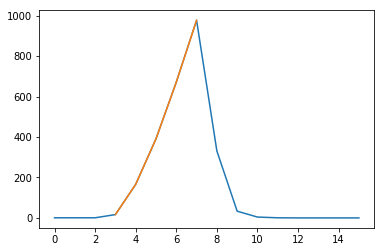

In [152]:
d_s = d.iloc[10:]
plt.plot(d['force'])
plt.plot(d_inc['force'])
plt.show()

Now we can create a function to filter out extraneous data

In [153]:
# Ignore values below 30 newtons
def get_real_data(d, f_thresh=30):
    idxmax = d['force'].idxmax()
    out = d.loc[(d['force'] > d['force'].shift()) & (d['force'] > f_thresh) & (d.index <= idxmax)]
    return out

In [154]:
# Make a copy of the dataframe with only the test data we're interested in
data_df['real_data'] = data_df['data'].apply(get_real_data)

Let's make sure that we're actually getting the values we're interested in

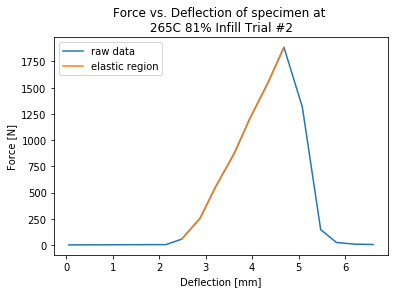

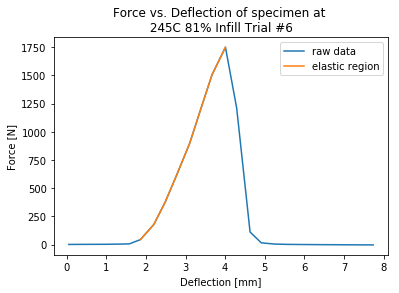

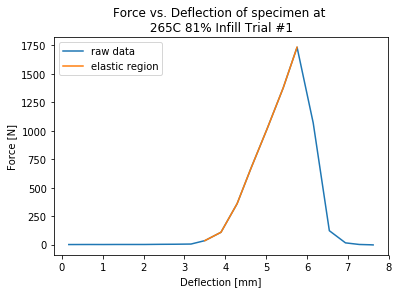

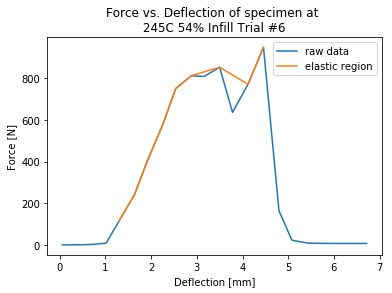

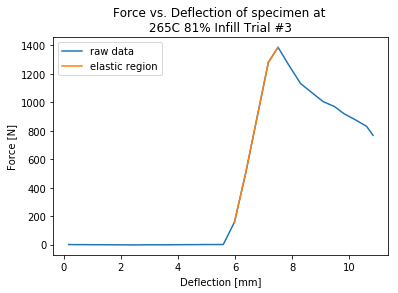

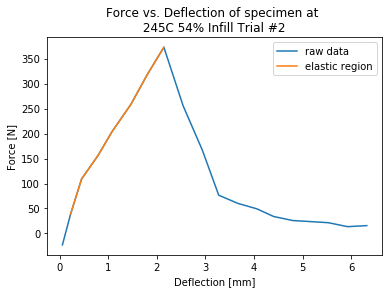

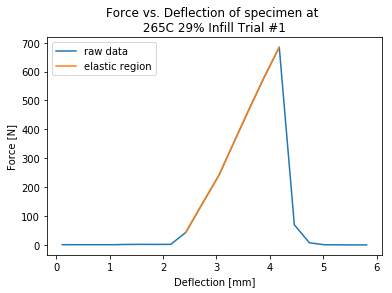

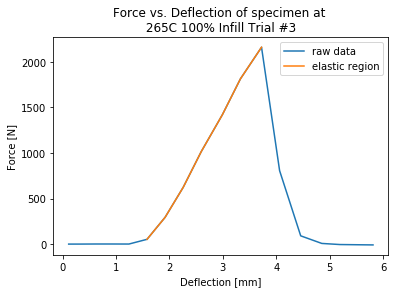

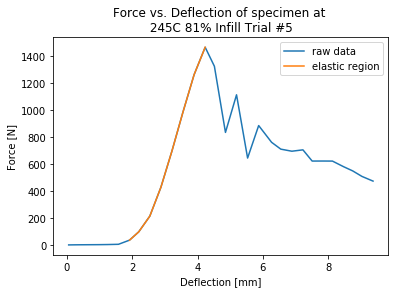

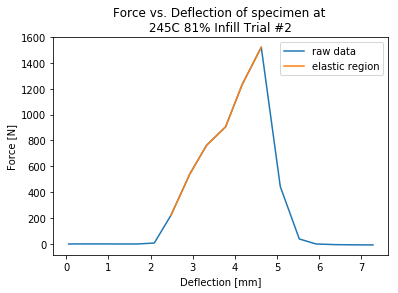

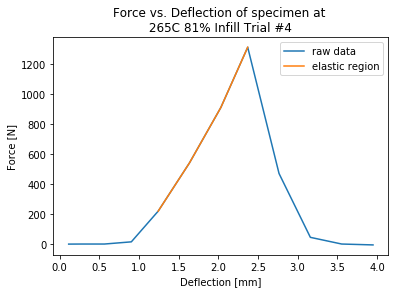

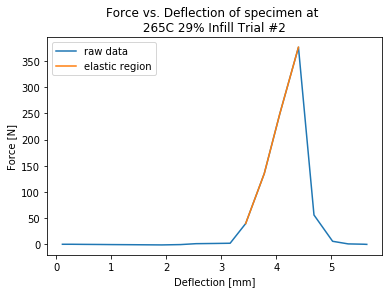

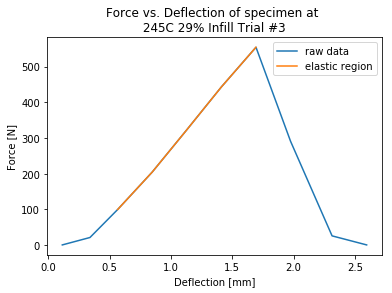

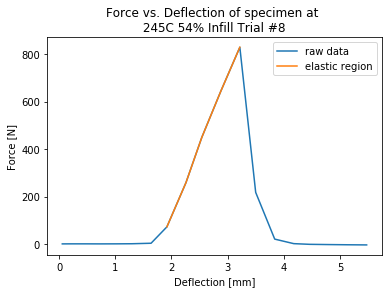

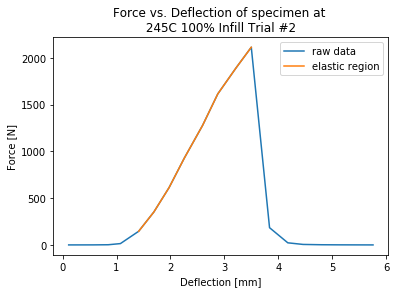

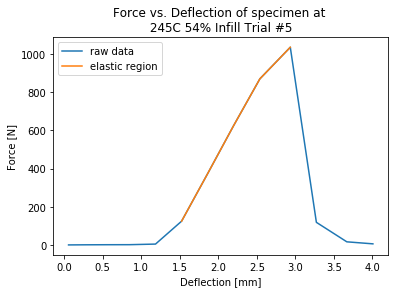

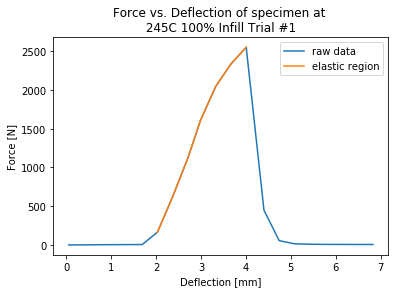

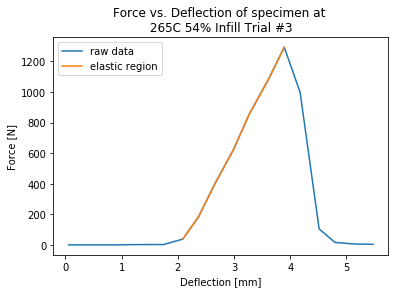

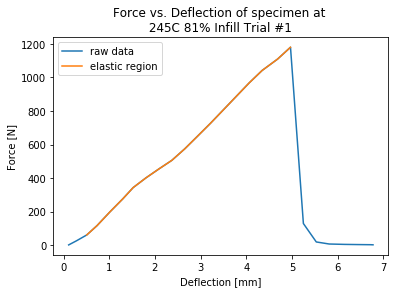

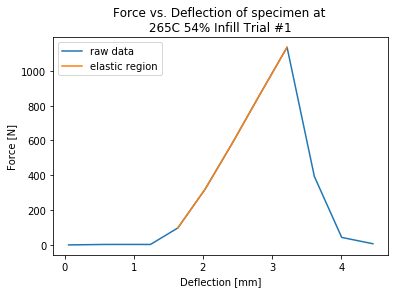

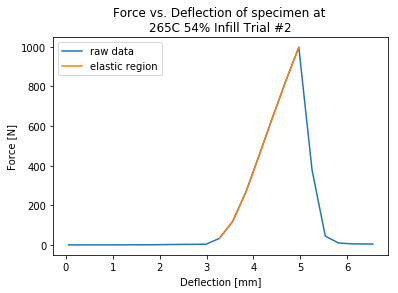

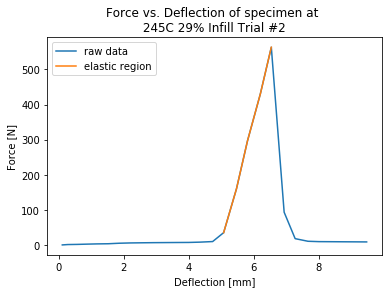

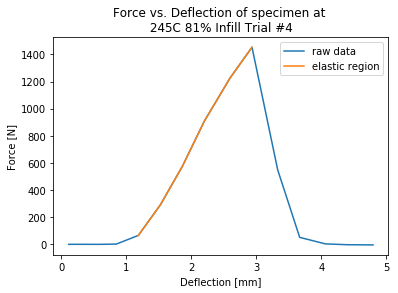

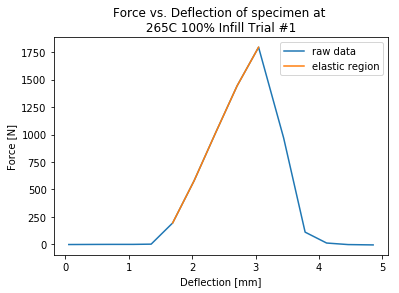

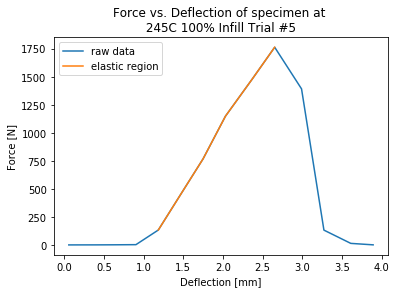

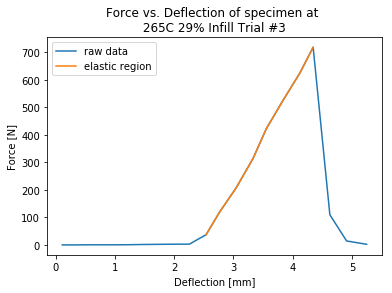

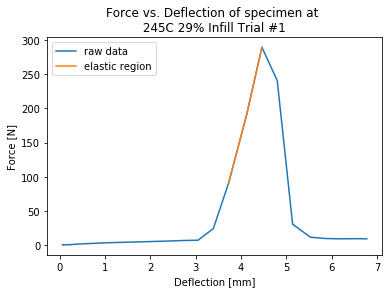

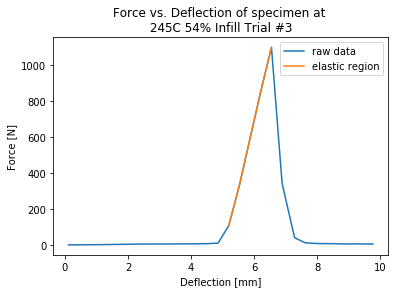

In [185]:
#for a in list(data_df.loc[data_df['comment'] == '']['data']): 
for row in data_df.itertuples():
    #print(row)
    temp = row._1
    Astar = row._2
    trial = row.trial
    comment = row.comment
    a = row.data
    b = row.real_data
    plt.plot(a['deflection'], a['force'], label='raw data')
    plt.plot(b['deflection'], b['force'], label='elastic region')
    plt.title(f'Force vs. Deflection of specimen at \n {temp}C {Astar*100:.0f}% Infill Trial #{trial} {comment}')
    plt.legend()
    plt.xlabel('Deflection [mm]')
    plt.ylabel('Force [N]')
    plt.show()



Now we can find the elastic modulous and ultimate tensile strength

In [157]:
def get_max_force(d):
    return d['force'].max()

def get_max_deflection(d):
    return d['deflection'].max()

def get_E(d):
    x = d['deflection']
    y = d['force']
    slope, intercept, r, p, stderr = linregress(x, y)
    return (slope, r, p, stderr)

In [158]:
data_df['max_force'] = data_df['real_data'].apply(get_max_force)
#data_df['max_deflection'] = data_df['real_data'].apply(get_max_deflection)
data_df[['E_slope', 'E_r', 'E_p', 'E_stderr']] = data_df['real_data'].apply(lambda x: pd.Series(get_E(x)))

In [159]:
data_df.head(10)

,temp [C],A*,trial,comment,data,real_data,max_force,E_slope,E_r,E_p,E_stderr
0,265,1.0000,5,Malformed layer (some walls not adhered_,deflection [in] force deflection 0 ...,deflection [in] force deflection 4 ...,977.454529,962.547875,0.997722,2.277879e-03,46.018302
1,265,0.8064,2,,deflection [in] force deflection 0...,deflection [in] force deflection 8...,1885.704956,850.067963,0.996927,1.003832e-06,29.872457
2,245,0.5376,7,Broke weird (clamping force too high),deflection [in] force deflection 0 ...,deflection [in] force deflection 12...,658.487549,556.255450,0.997533,2.466720e-03,27.678261
3,245,0.5376,1,Specimen slipped during test,deflection [in] force deflection ...,deflection [in] force deflection 5...,334.917938,369.274593,0.960741,3.925884e-02,75.406171
4,245,0.8064,6,,deflection [in] force deflection 0...,deflection [in] force deflection 7...,1749.134521,839.669103,0.993489,6.865914e-07,39.308808
5,245,1.0000,4,Sample started sliding in test,deflection [in] force deflection 0...,deflection [in] force deflection 5...,1625.165649,946.869379,0.983656,3.985171e-04,86.662685
6,265,0.8064,1,,deflection [in] force deflection 0...,deflection [in] force deflection 1...,1733.868896,784.288880,0.986639,3.934772e-05,57.917319
7,245,0.5376,6,,deflection [in] force deflection 0 ...,deflection [in] force deflection 5 ...,948.767578,236.604612,0.889990,1.303643e-03,45.817811
8,265,0.8064,3,,deflection [in] force deflection 0...,deflection [in] force deflection 1...,1386.858765,844.627797,0.991237,9.834192e-04,64.985162
9,245,0.5376,2,,deflection [in] force deflection 0 ...,deflection [in] force deflection 1 ...,372.650391,165.612767,0.996237,1.664996e-06,6.443462


The values given are in terms of absolute values (force/deflection), we want them in relative terms (stress/strain)

In [160]:
# part geometry
a = 10 # outer width (mm)
A = (a*10**-3)**2 # cross sectional area (m^2)
l1 = 40 # gauge length (mm)

data_max_force = data_df['max_force'].to_numpy()
#data_max_deflection = data_df['max_deflection'].to_numpy()
data_E_slope = data_df['E_slope'].to_numpy()
data_Astar = data_df['A*'].to_numpy()

data_A = np.multiply(data_Astar, A) 
data_max_stress = np.divide(data_max_force, data_A)
data_E = np.multiply(np.divide(data_E_slope, data_A), l1)

data_df['A'] = data_A.tolist()
data_df['max_stress'] = data_max_stress.tolist()
data_df['E'] = data_E.tolist()

data_df

,temp [C],A*,trial,comment,data,real_data,max_force,E_slope,E_r,E_p,E_stderr,A,max_stress,E
0,265,1.0000,5,Malformed layer (some walls not adhered_,deflection [in] force deflection 0 ...,deflection [in] force deflection 4 ...,977.454529,962.547875,0.997722,2.277879e-03,46.018302,0.000100,9.774545e+06,3.850191e+08
1,265,0.8064,2,,deflection [in] force deflection 0...,deflection [in] force deflection 8...,1885.704956,850.067963,0.996927,1.003832e-06,29.872457,0.000081,2.338424e+07,4.216607e+08
2,245,0.5376,7,Broke weird (clamping force too high),deflection [in] force deflection 0 ...,deflection [in] force deflection 12...,658.487549,556.255450,0.997533,2.466720e-03,27.678261,0.000054,1.224865e+07,4.138805e+08
3,245,0.5376,1,Specimen slipped during test,deflection [in] force deflection ...,deflection [in] force deflection 5...,334.917938,369.274593,0.960741,3.925884e-02,75.406171,0.000054,6.229872e+06,2.747579e+08
4,245,0.8064,6,,deflection [in] force deflection 0...,deflection [in] force deflection 7...,1749.134521,839.669103,0.993489,6.865914e-07,39.308808,0.000081,2.169066e+07,4.165025e+08
5,245,1.0000,4,Sample started sliding in test,deflection [in] force deflection 0...,deflection [in] force deflection 5...,1625.165649,946.869379,0.983656,3.985171e-04,86.662685,0.000100,1.625166e+07,3.787478e+08
6,265,0.8064,1,,deflection [in] force deflection 0...,deflection [in] force deflection 1...,1733.868896,784.288880,0.986639,3.934772e-05,57.917319,0.000081,2.150135e+07,3.890322e+08
7,245,0.5376,6,,deflection [in] force deflection 0 ...,deflection [in] force deflection 5 ...,948.767578,236.604612,0.889990,1.303643e-03,45.817811,0.000054,1.764821e+07,1.760451e+08
8,265,0.8064,3,,deflection [in] force deflection 0...,deflection [in] force deflection 1...,1386.858765,844.627797,0.991237,9.834192e-04,64.985162,0.000081,1.719815e+07,4.189622e+08
9,245,0.5376,2,,deflection [in] force deflection 0 ...,deflection [in] force deflection 1 ...,372.650391,165.612767,0.996237,1.664996e-06,6.443462,0.000054,6.931741e+06,1.232238e+08


In [161]:
data_245 = data_df.loc[data_df['temp [C]'] == 245]

data_245_max_force = data_245['max_force'].to_numpy()
data_245_E_slope = data_245['E_slope'].to_numpy()
data_245_A = data_245['A'].to_numpy()

data_245_max_stress = data_245['max_stress'].to_numpy()
data_245_E = data_245['E'].to_numpy()


data_265 = data_df.loc[data_df['temp [C]'] == 265]

data_265_max_force = data_265['max_force'].to_numpy()
data_265_E_slope = data_265['E_slope'].to_numpy()
data_265_A = data_265['A'].to_numpy()

data_265_max_stress = data_265['max_stress'].to_numpy()
data_265_E = data_265['E'].to_numpy()

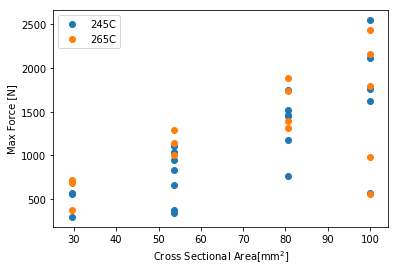

In [162]:
plt.scatter(data_245_A*1000000, data_245_max_force, label='245C')
plt.scatter(data_265_A*1000000, data_265_max_force, label='265C')

plt.ylabel('Max Force [N]')
plt.xlabel('Cross Sectional Area[mm$^2$]')
plt.legend()

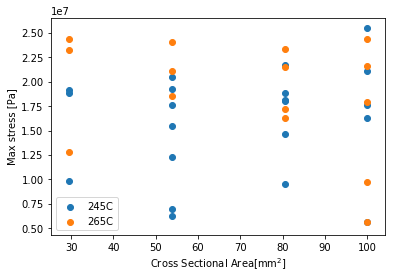

In [163]:
plt.scatter(data_245_A*1000000, data_245_max_stress, label='245C')
plt.scatter(data_265_A*1000000, data_265_max_stress, label='265C')
plt.ylabel('Max stress [Pa]')
plt.xlabel('Cross Sectional Area[mm$^2$]')
plt.legend()

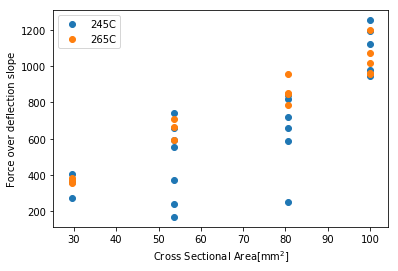

In [164]:
plt.scatter(data_245_A*1000000, data_245_E_slope, label='245C')
plt.scatter(data_265_A*1000000, data_265_E_slope, label='265C')
plt.ylabel('Force over deflection slope')
plt.xlabel('Cross Sectional Area[mm$^2$]')
plt.legend()

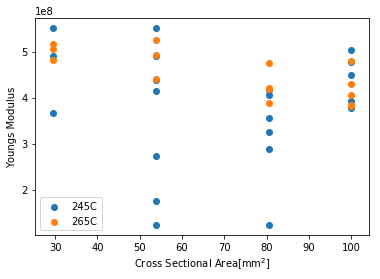

In [165]:
plt.scatter(data_245_A*1000000, data_245_E, label='245C')
plt.scatter(data_265_A*1000000, data_265_E, label='265C')
plt.ylabel('Youngs Modulus')
plt.xlabel('Cross Sectional Area[mm$^2$]')
plt.legend()

(array([ 2.,  1.,  0.,  2.,  1.,  3., 10.,  4.,  9.,  4.]),
 array([1.23223785e+08, 1.66155919e+08, 2.09088052e+08, 2.52020185e+08,
        2.94952319e+08, 3.37884452e+08, 3.80816586e+08, 4.23748719e+08,
        4.66680852e+08, 5.09612986e+08, 5.52545119e+08]),
 <a list of 10 Patch objects>)

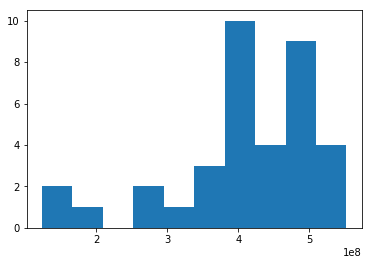

In [166]:
plt.hist(np.append(data_245_E, data_265_E))

Let's drop samples where we noticed abnormal behavior (i.e. there was a comment to go with it)

In [167]:
data_df = data_df.loc[data_df['comment'] == '']

In [168]:
data_245 = data_df.loc[data_df['temp [C]'] == 245]

data_245_max_force = data_245['max_force'].to_numpy()
data_245_E_slope = data_245['E_slope'].to_numpy()
data_245_A = data_245['A'].to_numpy()

data_245_max_stress = data_245['max_stress'].to_numpy()
data_245_E = data_245['E'].to_numpy()


data_265 = data_df.loc[data_df['temp [C]'] == 265]

data_265_max_force = data_265['max_force'].to_numpy()
data_265_E_slope = data_265['E_slope'].to_numpy()
data_265_A = data_265['A'].to_numpy()

data_265_max_stress = data_265['max_stress'].to_numpy()
data_265_E = data_265['E'].to_numpy()

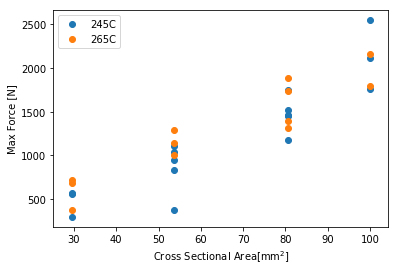

In [169]:
plt.scatter(data_245_A*1000000, data_245_max_force, label='245C')
plt.scatter(data_265_A*1000000, data_265_max_force, label='265C')

plt.ylabel('Max Force [N]')
plt.xlabel('Cross Sectional Area[mm$^2$]')
plt.legend()

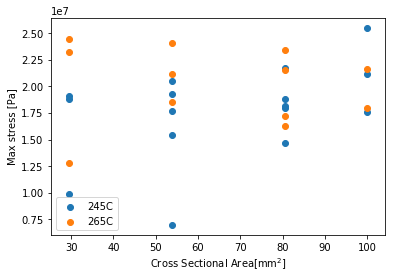

In [170]:
plt.scatter(data_245_A*1000000, data_245_max_stress, label='245C')
plt.scatter(data_265_A*1000000, data_265_max_stress, label='265C')
plt.ylabel('Max stress [Pa]')
plt.xlabel('Cross Sectional Area[mm$^2$]')
plt.legend()

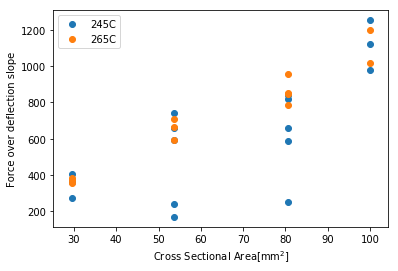

In [171]:
plt.scatter(data_245_A*1000000, data_245_E_slope, label='245C')
plt.scatter(data_265_A*1000000, data_265_E_slope, label='265C')
plt.ylabel('Force over deflection slope')
plt.xlabel('Cross Sectional Area[mm$^2$]')
plt.legend()

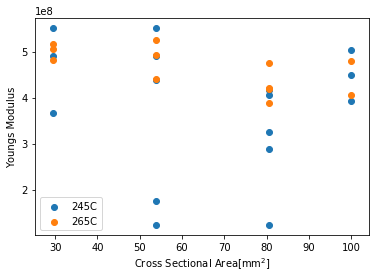

In [172]:
plt.scatter(data_245_A*1000000, data_245_E, label='245C')
plt.scatter(data_265_A*1000000, data_265_E, label='265C')
plt.ylabel('Youngs Modulus')
plt.xlabel('Cross Sectional Area[mm$^2$]')
plt.legend()

(array([2., 1., 0., 1., 1., 1., 7., 3., 8., 4.]),
 array([1.23223785e+08, 1.66155919e+08, 2.09088052e+08, 2.52020185e+08,
        2.94952319e+08, 3.37884452e+08, 3.80816586e+08, 4.23748719e+08,
        4.66680852e+08, 5.09612986e+08, 5.52545119e+08]),
 <a list of 10 Patch objects>)

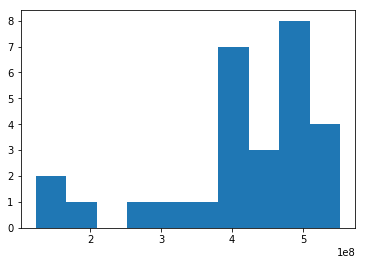

In [173]:
plt.hist(np.append(data_245_E, data_265_E))

In [174]:
E_avg_245, E_std_245 = norm.fit(data_245_E)

E_avg_265, E_std_265 = norm.fit(data_265_E)

E_avg ,E_std = norm.fit(data_df['E'].to_numpy())

table = [
    ["", "avg", "stddev"],
    ["E (245C)", f'{E_avg_245:.4e}', f'{E_std_245:.4e}'],
    ["E (265C)", f'{E_avg_265:.4e}', f'{E_std_265:.4e}'],
    ["E (overall)", f'{E_avg:.4e}', f'{E_std:.4e}'],
]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

,avg,stddev
E (245C),3.8123e+08,1.3552e+08
E (265C),4.6312e+08,4.3901e+07
E (overall),4.1633e+08,1.1386e+08


In [175]:
UTS_avg_245, UTS_std_245 = norm.fit(data_245_max_stress)

UTS_avg_265, UTS_std_265 = norm.fit(data_265_max_stress)

UTS_avg, UTS_std = norm.fit(data_df['max_stress'].to_numpy())

table = [
    ["", "avg", "stddev"],
    ["UTS (245C)", f'{UTS_avg_245:.4e}', f'{UTS_std_245:.4e}'],
    ["UTS (265C)", f'{UTS_avg_265:.4e}', f'{UTS_std_265:.4e}'],
    ["UTS (overall)", f'{UTS_avg:.4e}', f'{UTS_std:.4e}'],
]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

,avg,stddev
UTS (245C),1.7698e+07,4.3034e+06
UTS (265C),2.0172e+07,3.4618e+06
UTS (overall),1.8758e+07,4.1494e+06


/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([7.17442462e-08, 0.00000000e+00, 7.17442462e-08, 7.17442462e-08,
        1.43488492e-07, 0.00000000e+00, 0.00000000e+00, 2.15232739e-07,
        7.17442462e-08, 2.15232739e-07]),
 array([12793803.22690217, 13955336.55910326, 15116869.89130435,
        16278403.22350543, 17439936.55570652, 18601469.88790761,
        19763003.2201087 , 20924536.55230978, 22086069.88451087,
        23247603.21671195, 24409136.54891304]),
 <a list of 10 Patch objects>)

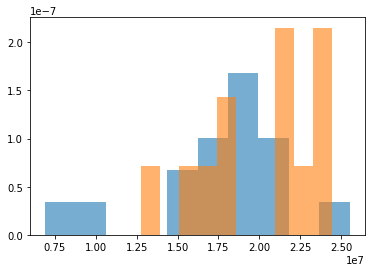

In [176]:
plt.hist(data_245_max_stress, bins=10, alpha=0.6, normed=True)
plt.hist(data_265_max_stress, bins=10, alpha=0.6, normed=True)
#plt.hist(data_df['max_stress'].to_numpy(), bins=10, alpha=0.6, normed=True)

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([6.08633060e-09, 6.08633060e-09, 1.21726612e-08, 6.08633060e-09,
        0.00000000e+00, 0.00000000e+00, 1.82589918e-08, 6.08633060e-09,
        6.08633060e-09, 1.21726612e-08]),
 array([3.89032182e+08, 4.02724066e+08, 4.16415951e+08, 4.30107835e+08,
        4.43799719e+08, 4.57491603e+08, 4.71183487e+08, 4.84875371e+08,
        4.98567255e+08, 5.12259139e+08, 5.25951024e+08]),
 <a list of 10 Patch objects>)

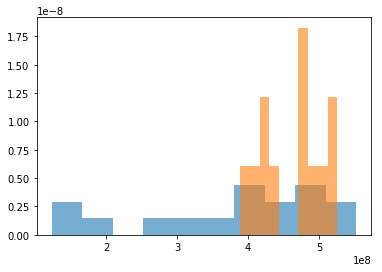

In [177]:
plt.hist(data_245_E, bins=10, alpha=0.6, normed=True)
plt.hist(data_265_E, bins=10, alpha=0.6, normed=True)
#plt.hist(data_df['max_stress'].to_numpy(), bins=10, alpha=0.6, normed=True)

In [178]:
len(data_245_max_stress)

16

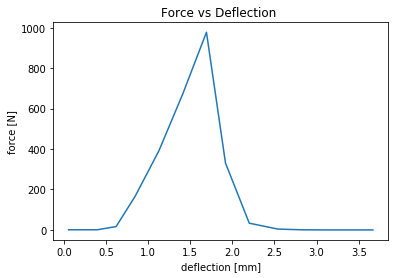

In [179]:
plt.plot(d['deflection'], d['force'])
plt.title('Force vs Deflection of  ')
plt.ylabel('force [N]')
plt.xlabel('deflection [mm]')
plt.show()